In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
import pandas as pd
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)
import sys

sys.path.append("../")
from train_model import PARAMETERS

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [18]:
DEFAULT_WS = PARAMETERS["window_size"]
print(DEFAULT_WS)

20


In [19]:
normal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
painco = folder_to_sequence("PAINCO", DEFAULT_WS)

scaler = MinMaxScaler_AE()
scaler.fit(normal)
normal = scaler.transform(normal)
painco = scaler.transform(painco)
autoencoder = keras.models.load_model("../models/best_model.keras")

100%|██████████| 13/13 [00:00<00:00, 43.79it/s]


In [22]:
from joblib import Parallel, delayed


# Function to perform a single stochastic forward pass with dropout
def stochastic_forward_pass(model, X_test):
    return model(X_test, training=True).numpy()


# Function to perform MC Dropout with parallel computation
def mc_dropout_predict_parallel(model, X_test, n_forward_passes=100, n_jobs=-1):
    # Use joblib to run parallel forward passes
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(stochastic_forward_pass)(model, X_test) for _ in range(n_forward_passes)
    )

    # Convert predictions list into numpy array
    predictions = np.array(
        predictions
    )  # Shape: (n_forward_passes, n_samples, time_steps)

    # Compute mean and uncertainty (standard deviation)
    mean_prediction = np.mean(predictions, axis=0)  # Mean across forward passes
    assert mean_prediction.shape[1] == X_test.shape[1], f"Shape mismatch: {mean_prediction.shape} != {X_test.shape}"

    uncertainty = np.std(predictions, axis=0)  # Uncertainty (std dev)

    return mean_prediction, uncertainty

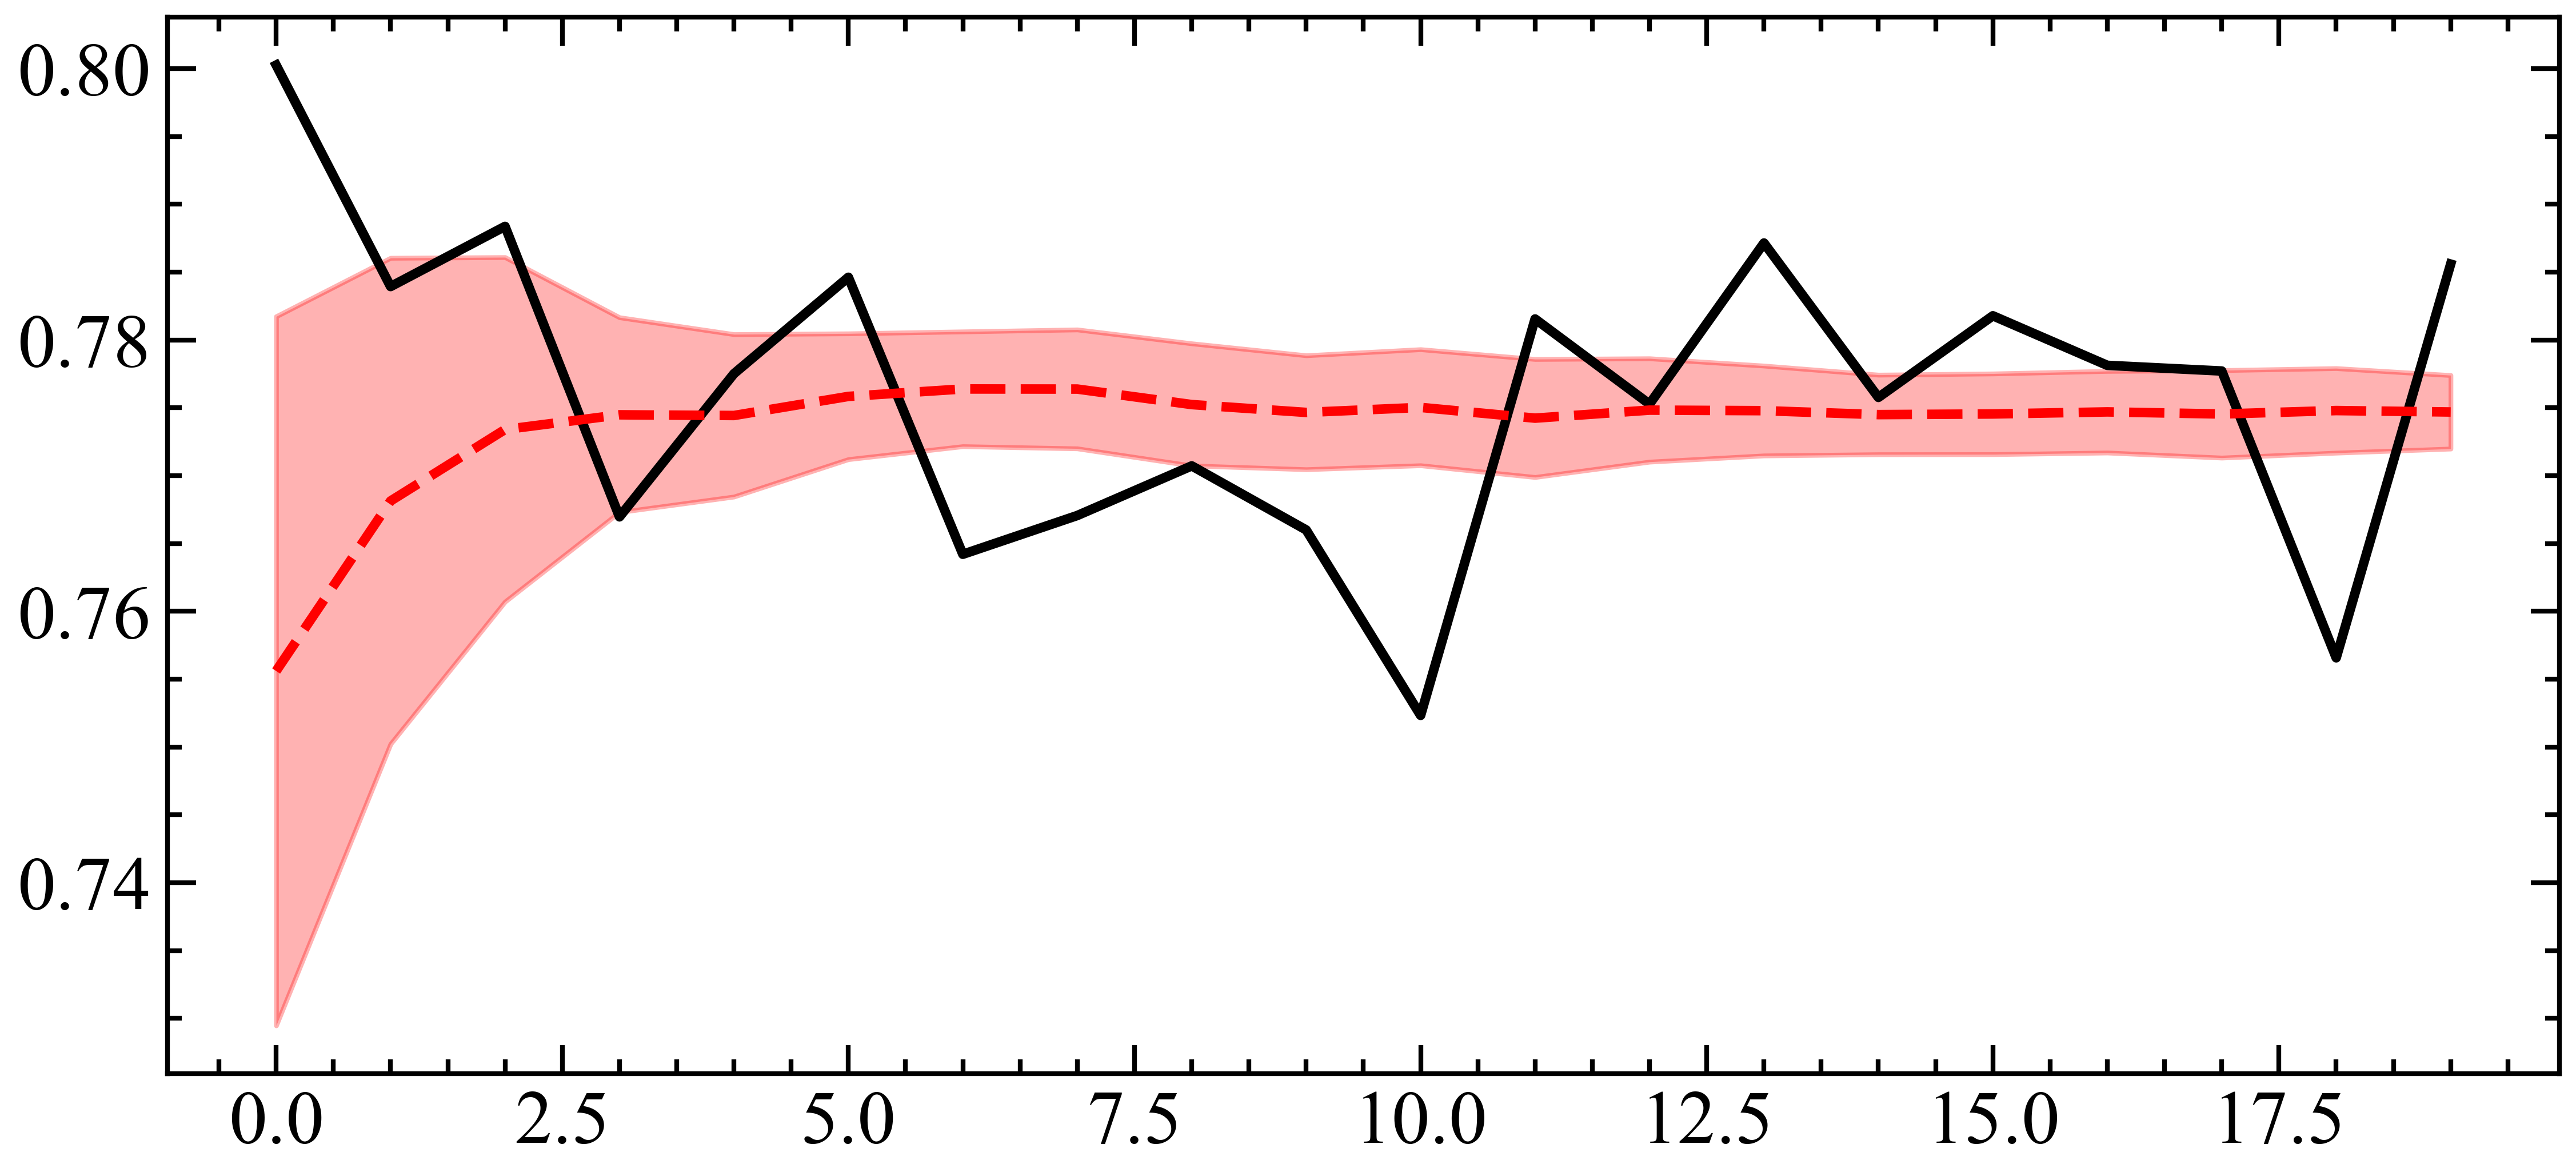

In [23]:
index: int = 30000
mean, std = mc_dropout_predict_parallel(
    autoencoder, np.expand_dims(normal[index], 0), 10
)

ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = range(len(normal[index]))

plt.plot(x, normal[index], label="Normal")
plt.plot(x, mean.flatten())
plt.fill_between(x, ymin, ymax, alpha=0.3, color="red");

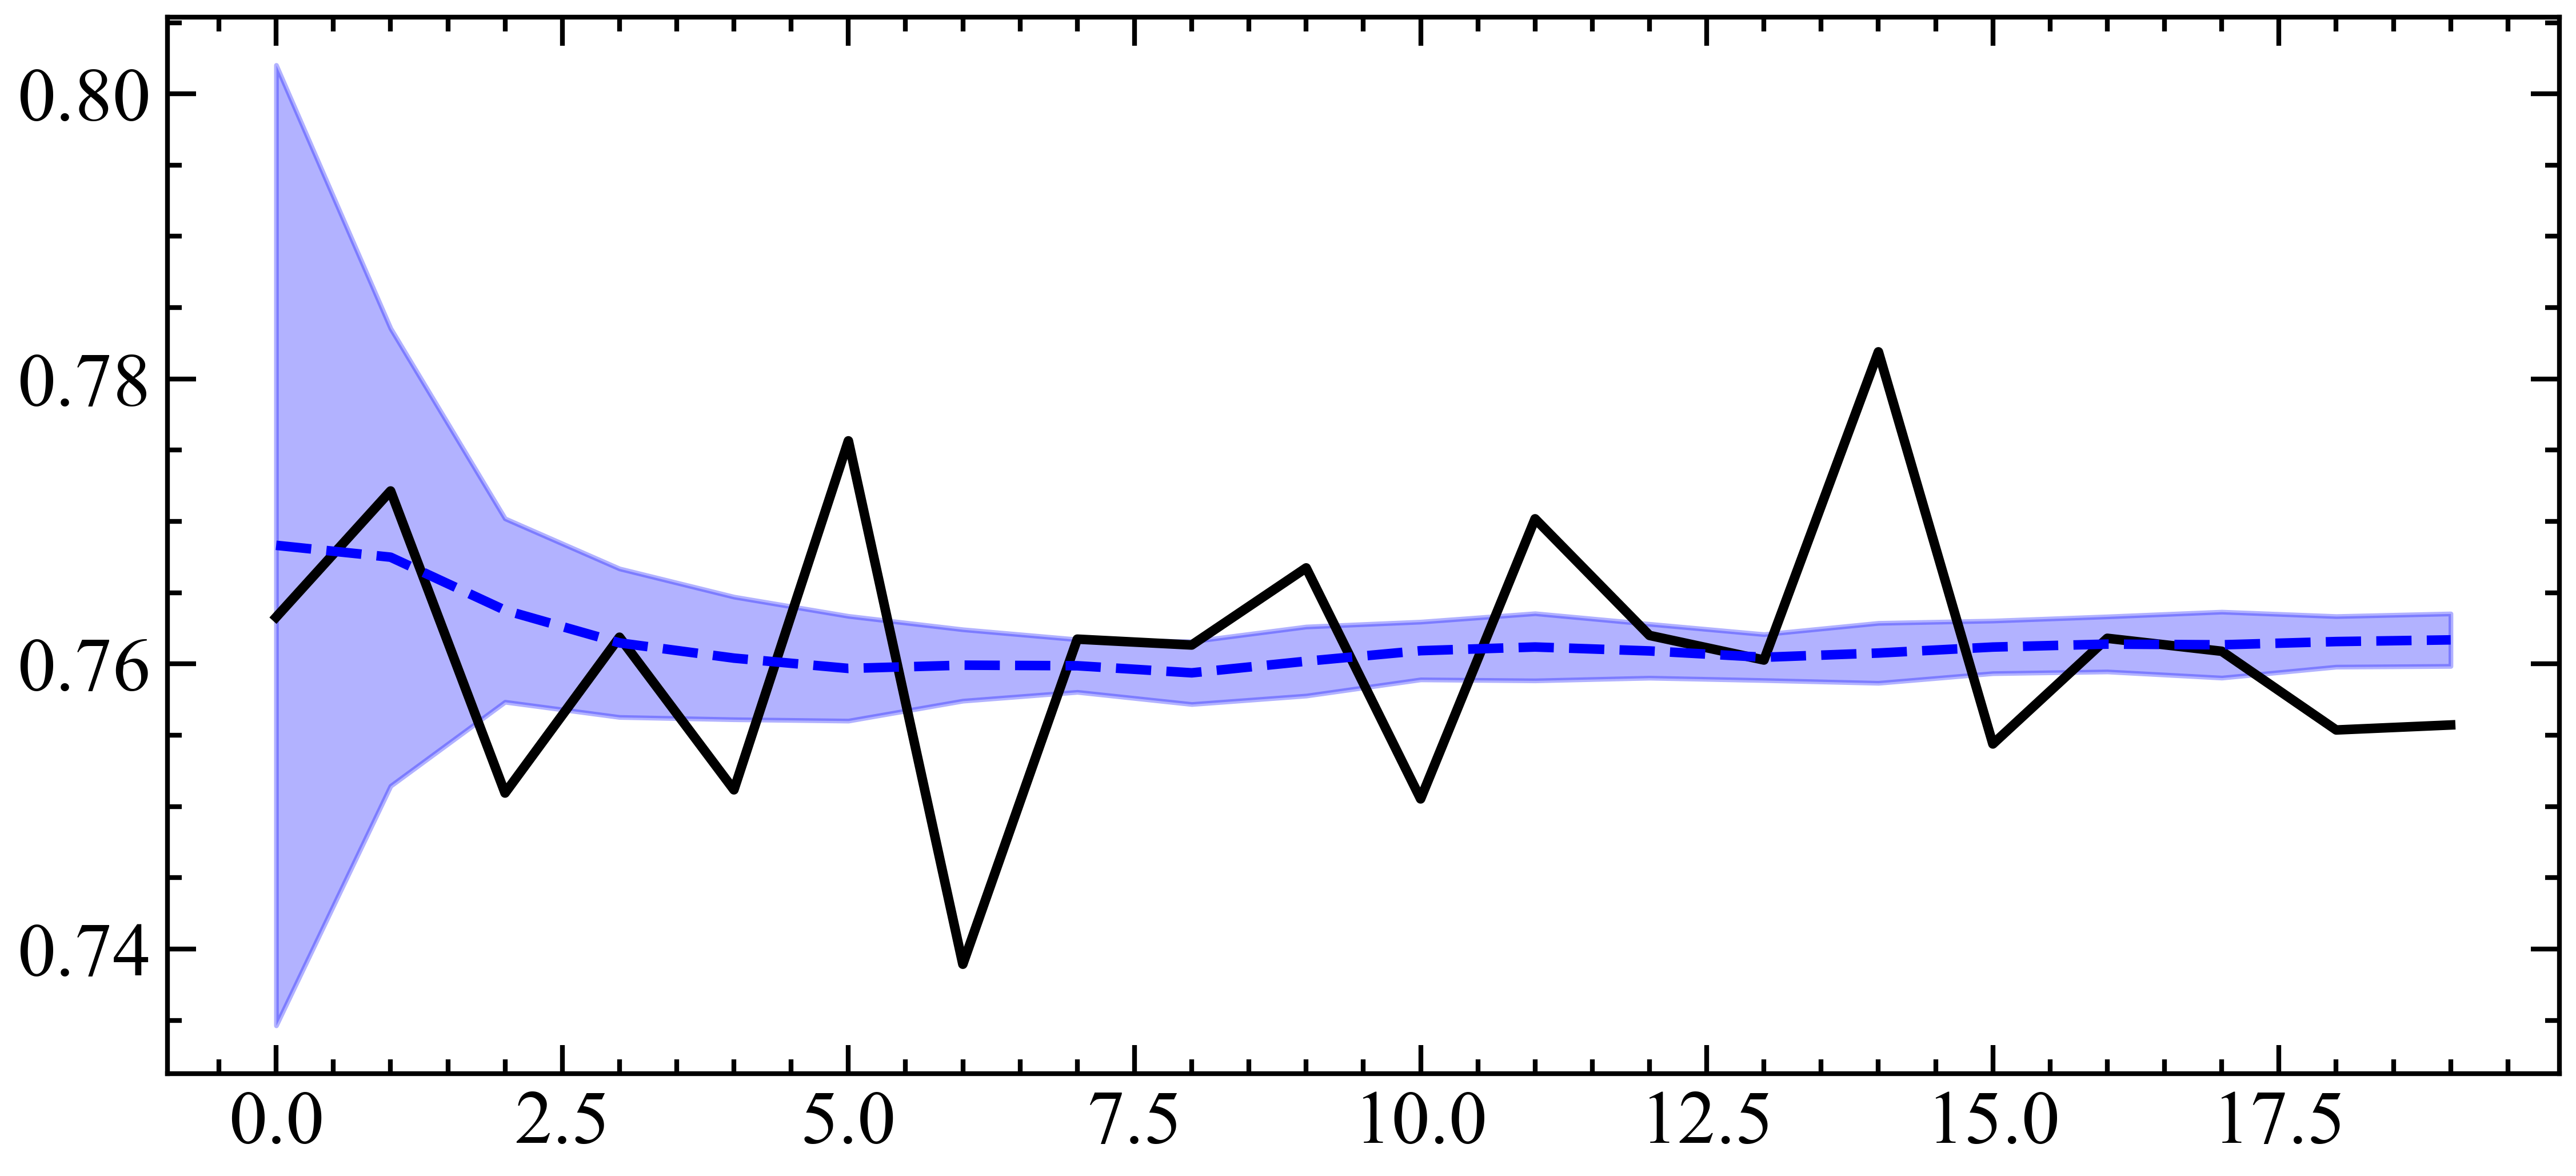

In [24]:
index: int = 1000
mean, std = mc_dropout_predict_parallel(
    autoencoder, painco[index].reshape(1, DEFAULT_WS, 1), 10
)

ymin = (mean - std).flatten()
ymax = (mean + std).flatten()
x = range(DEFAULT_WS)

plt.plot(x, painco[index], label="Normal")
plt.plot(x, mean.flatten(), c='blue')
plt.fill_between(x, ymin, ymax, alpha=0.3, color="blue");